# 0 - Instalation of modules

In [ ]:
#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [123]:
%reset

# 1 - Importing modules

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [2]:
data_folder = "../../Dataset/Movie/"

In [22]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [23]:
#On garde les NB_FILM films les plus notés
NB_FILM = 500
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(10944751, 3)

In [28]:
#On garde les users qui ont données une note sur au moins THRESH_USER % des films
THRESH_USER = 0.40
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [29]:
#On fait notre pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
user_title_df.to_csv(f"{data_folder}test_for_users.csv")
user_title_df.shape

(10103, 500)

# 4 - Colaborative filtering

In [3]:
#Récupérer les données si elles sont en local
user_title_df = pd.read_csv(f"{data_folder}test_for_users.csv", index_col=0)
user_title_df.shape

(10103, 500)

In [4]:
#Standardisation des lignes pour supprimer les biais
def normalization_mean(row):
    return row - row.mean()

def normalization_min_max(row):
    return (row - row.mean())/(row.max() - row.min())

def normalization_std(row):
    return (row - row.mean())/row.std()  

## 4.1 - Users to users

In [5]:
user_title = {}
user_title["min_max"] = user_title_df.fillna(0).apply(normalization_min_max, axis=1)
user_title["mean"] = user_title_df.fillna(0).apply(normalization_mean, axis=1)
user_title["std"] = user_title_df.fillna(0).apply(normalization_std, axis=1)

In [6]:
#Création de la matrice de cosinus distance
all_users = user_title_df.index
similarity_users = {"Cosinus" : {}, "Pearson" : {}}

for method in user_title.keys():
    cos = cosine_similarity(user_title[method])
    similarity_users["Cosinus"][method] = pd.DataFrame(cos, index=all_users, columns=all_users)
    np.fill_diagonal(similarity_users["Cosinus"][method].values, 0)

    corr = np.corrcoef(user_title[method])
    similarity_users["Pearson"][method] = pd.DataFrame(corr, index=all_users, columns=all_users)
    np.fill_diagonal(similarity_users["Pearson"][method].values, 0)

del(cos)
del(corr)

In [7]:
#On devine la note en fonction des candidtats similaires
def guess_rate(user, title, distance, method, N):
    similar_mat = similarity_users[distance][method]
    all_similar_users = similar_mat.loc[user].sort_values(ascending=False).index
    user_title_mat = user_title[method]
    
    rate = 0
    weight = 0
    k = 0
    i = 0

    while (k < N):
        similar_user = all_similar_users[i]
        r = user_title_mat.loc[similar_user, title]

        if not (pd.isnull(r)):
            w = similar_mat.loc[similar_user, user]
            rate += w*r
            weight += w
            k += 1

        i += 1

    return rate/weight

In [8]:
def get_similar_movies_from_users(user_id, distance, method, N):
    all_rates = []
    keep_movies = []

    for movie in tqdm(user_title_df.columns):
        if (pd.isnull(user_title_df.loc[user_id, movie])):
            all_rates.append(guess_rate(user_id, movie, distance, method, N))
            keep_movies.append(movie)

    return pd.Series(all_rates, keep_movies).sort_values(ascending=False)

In [9]:
recommanded_movies = {"Cosinus" : {"min_max" : [], "mean" : [], "std" : []}, "Pearson" : {"min_max" : [], "mean" : [], "std" : []}}

for distance in recommanded_movies.keys():
    for method in recommanded_movies[distance].keys():
        recommanded_movies[distance][method] = get_similar_movies_from_users(12, distance, method, 10).index

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
cos_recommanded = pd.DataFrame.from_dict(recommanded_movies["Cosinus"])
corr_recommanded = pd.DataFrame.from_dict(recommanded_movies["Pearson"])
((cos_recommanded == corr_recommanded).all()).all()
#Aucune différence entre Cosinus et Pearson

True

In [51]:
(cos_recommanded["min_max"] == cos_recommanded["mean"]).all()       #100% pareil
np.mean(cos_recommanded["min_max"] == cos_recommanded["std"])*100   #39.91% pareil

39.91935483870967

In [50]:
k = 0
arg_diff = []
for movie in cos_recommanded["mean"].values:
    arg = np.where(cos_recommanded["std"] == movie)[0][0]
    if (arg != k):
        arg_diff.append(abs(k-arg))
    k += 1
np.mean(arg_diff)
#Il n'y a que 2/3 places de différences entre chaque films

2.4563758389261743

In [77]:
#On compare les deux méthodes
from time import time

NB_USER = 20
NB_MOVIE = 20
MAX = 11
STEP = 2

stats = {}

for N in tqdm([i*STEP for i in range(1, MAX)]):
    stats[f"N = {N}"] = {}

    for distance in ["Cosinus", "Pearson"]:
        stats[f"N = {N}"][distance] = {"min_max" : [], "mean" : [], "std" : []}

        for user_id in user_title_df.index[:NB_USER]:
            all_rated_movies = user_title_df.loc[user_id].dropna()[:NB_MOVIE]

            for movie in all_rated_movies.index:
                for method in ["min_max", "mean", "std"]:
                    start = time()
                    rate = guess_rate(user_id, movie, distance, method, N)
                    stats[f"N = {N}"][distance][method].append(time() - start)

  0%|          | 0/10 [00:00<?, ?it/s]

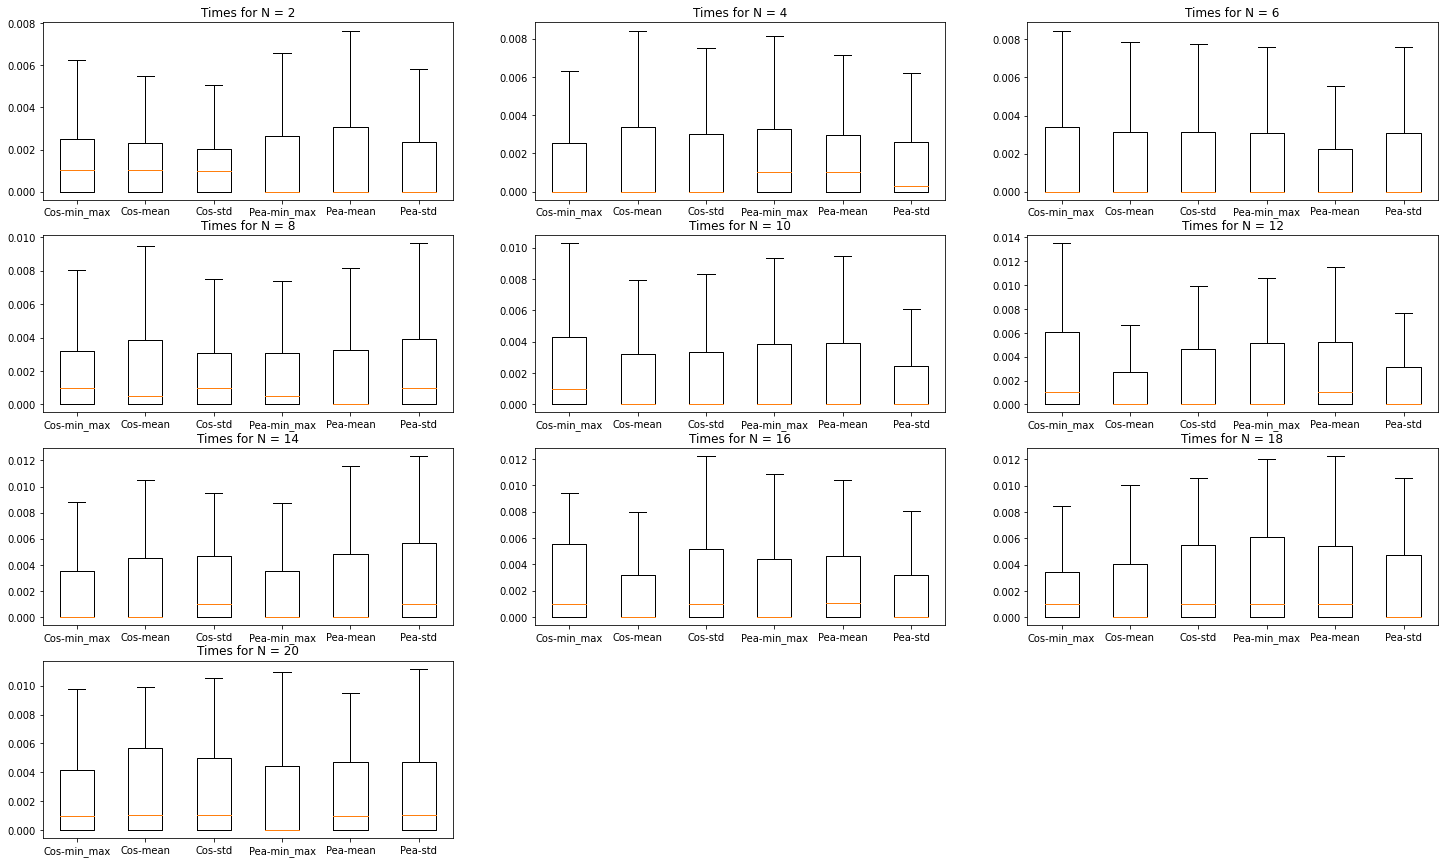

In [78]:
plt.figure(figsize=(25, 15))

k = 1
for key_N in stats.keys():
    plt.subplot(int((MAX-1)/3)+1, 3, k)  
    plots = []
    labels = []

    for distance in stats[key_N].keys():
        for method in stats[key_N][distance].keys():
            plots.append(stats[key_N][distance][method])
            labels.append(f"{distance[:3]}-{method}")

    plt.boxplot(plots, labels=labels, showfliers=False)
    plt.title(f"Times for {key_N}")
    k += 1

plt.show()

In [85]:
#On compare les deux méthodes
from time import time

NB_USER = 20
NB_MOVIE = 20
MAX = 100
STEP = 2

stats = {}

for N in tqdm([i*STEP for i in range(1, MAX)]):
    for distance in ["Cosinus", "Pearson"]:
        stats[distance] = {"min_max" : [], "mean" : [], "std" : []}

        for user_id in user_title_df.index[:NB_USER]:
            all_rated_movies = user_title_df.loc[user_id].dropna()[:NB_MOVIE]

            for movie in all_rated_movies.index:
                for method in ["min_max", "mean", "std"]:
                    start = time()
                    rate = guess_rate(user_id, movie, distance, method, N)
                    stats[distance][method].append(time() - start)

  0%|          | 0/99 [00:00<?, ?it/s]

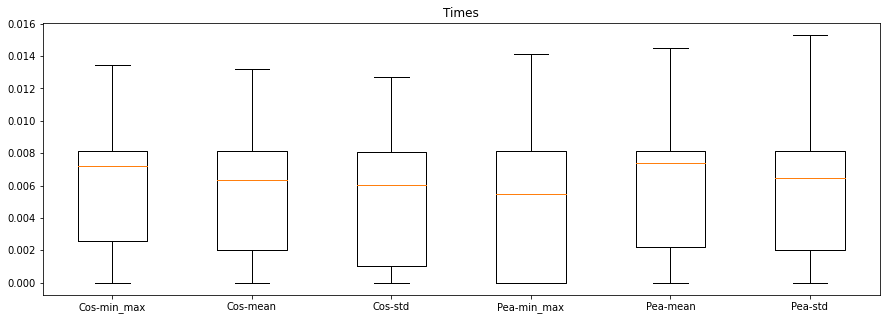

In [87]:
plt.figure(figsize=(15, 5))

plots = []
labels = []

for distance in stats.keys():
    for method in stats[distance].keys():
        plots.append(stats[distance][method])
        labels.append(f"{distance[:3]}-{method}")

plt.boxplot(plots, labels=labels, showfliers=False)
plt.title(f"Times")
plt.show()

## 4.2 - Movie to movie

In [16]:
user_title_std = user_title_df.apply(standardize, axis=0).fillna(0)
user_title_std.shape

(24710, 500)

In [17]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(user_title_std.T)
cos_movies_df = pd.DataFrame(cos, index=user_title_std.columns, columns=user_title_std.columns)
np.fill_diagonal(cos_movies_df.values, 0)
del(cos)

In [18]:
def get_similar_movies_from_movies(user_id):
    similar_movies = pd.DataFrame()

    movies_rates = user_title_df.loc[user_id].dropna()
    movies = movies_rates.index
    rates = movies_rates.values
    user = [(movies[i], rates[i]) for i in range(len(rates))]

    for movie, rate in tqdm(user):
        movie_list = (cos_movies_df.loc[:, movie]*(rate-2.5)).sort_values(ascending=False)
        similar_movies = similar_movies.append(movie_list)

    
    similar_movies = similar_movies.T.drop([movie for movie, rate in user], axis=0)
    return similar_movies.sum(axis=1).sort_values(ascending=False)

In [19]:
get_similar_movies_from_movies(3)

  0%|          | 0/199 [00:00<?, ?it/s]

Saving Private Ryan (1998)                             40.106259
Spider-Man 2 (2004)                                    39.596884
Sixth Sense, The (1999)                                38.783319
Indiana Jones and the Last Crusade (1989)              38.465264
Up (2009)                                              37.900991
                                                         ...    
City Slickers II: The Legend of Curly's Gold (1994)    11.547058
Congo (1995)                                           11.474667
French Kiss (1995)                                     11.226061
Executive Decision (1996)                              10.659839
Disclosure (1994)                                       9.076215
Length: 301, dtype: float64

## 4.3 - Mix

In [20]:
def recommanded_movies(user_id):
    get_users = get_similar_movies_from_users(user_id).index
    get_movies = get_similar_movies_from_movies(user_id).index

    arg_movies = []
    for title in get_users:
        arg_movies.append(int(np.argwhere(get_movies == title)))

    recommanded = pd.DataFrame(index=get_users, columns=["Arg Users", "Arg Movies"], data=np.array([range(len(arg_movies)), arg_movies]).T)
    recommanded["Mean"] = recommanded.mean(axis=1)

    return recommanded.sort_values(by="Mean")["Mean"]

In [21]:
user = cluster.index[1]
recommanded_movies(user)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

Star Wars: Episode VI - Return of the Jedi (1983)                  5.5
Memento (2000)                                                    10.0
X-Men (2000)                                                      10.5
Pirates of the Caribbean: The Curse of the Black Pearl (2003)     12.0
Die Hard (1988)                                                   13.5
                                                                 ...  
Ed Wood (1994)                                                   196.0
Fantasia (1940)                                                  197.5
Johnny Mnemonic (1995)                                           197.5
First Knight (1995)                                              202.5
French Kiss (1995)                                               206.0
Name: Mean, Length: 214, dtype: float64

In [27]:
user = cluster.index[1]
t = recommanded_movies(user)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

In [33]:
t["X-Men (2000)"]

15.0